# Fall detector
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will use the previously learned data analysis methods and apply them to create a fall detector. After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating a fall detector.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. Finally, in part 4 you will create a fall detector.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- apply analysis methods for creating a fall detector.

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

> (For iPhone) If you have issues accessing the (live) calibrated data of the _Sensor Logger_ app, you need to enable motion and compas calibration on your phone as explained [here](https://www.lifewire.com/how-to-calibrate-an-iphone-4172146). You will notice this once the live view and the export yield empty results.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the data that you have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Load one of your individuals recordings in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [2]:
#// BEGIN_TODO [5ARB0_FallDetector_2_1] Read, merge and select data


def read_and_merge(data_dir: str):
    """
    Read the relevant CSV files from `data_dir` and return a merged dataframe.

    Args:
        data_dir: directory containing the sensor recordings (do not include trailing slash)

    Returns:
        A dataframe with the merged sensor data or None if any file is not found.
    """
    csv_filenames = ["Accelerometer.csv", "Gyroscope.csv", "Gravity.csv"]
    column_drop_filter = ["time"]
    index_column = "seconds_elapsed"

    csv_filepath = os.path.join(data_dir, csv_filenames[0])
    try:
        data = pd.read_csv(csv_filepath, index_col=index_column)
    except FileNotFoundError:
        print(f"File not found: {csv_filepath}")
        return None
    data.drop(labels=column_drop_filter, axis=1, inplace=True)
    suffix = csv_filenames[0].split(".")[0]
    data.rename(columns=lambda name: f"{name}_{suffix}", inplace=True)

    for csv_filename in csv_filenames[1:]:
        csv_filepath = os.path.join(data_dir, csv_filename)
        try:
            df_tmp = pd.read_csv(csv_filepath, index_col=index_column)
        except FileNotFoundError:
            print(f"File not found: {csv_filepath}")
            return None
        df_tmp.drop(labels=column_drop_filter, axis=1, inplace=True)
        suffix = csv_filename.split(".")[0]
        df_tmp.rename(columns=lambda name: f"{name}_{suffix}", inplace=True)
        data = pd.merge_asof(data, df_tmp, left_index=True, right_index=True)

    data.dropna(inplace=True)
    data = data.loc[:,~data.columns.duplicated()]  # Remove duplicate columns
    return data

data_dir = "./Data/Fall-2023-09-27-12-37-58"
data = read_and_merge(data_dir)


#// END_TODO [5ARB0_FallDetector_2_1]

In [3]:
data

,z_Accelerometer,y_Accelerometer,x_Accelerometer,z_Gyroscope,y_Gyroscope,x_Gyroscope,z_Gravity,y_Gravity,x_Gravity
seconds_elapsed,,,,,,,,,
0.021537,-0.237804,-0.126507,-0.074561,-0.180291,-0.051861,0.033199,-9.784923,-0.638440,0.134416
0.031593,-0.138457,-0.086790,-0.015828,-0.173847,-0.045604,0.038190,-9.784761,-0.641646,0.130900
0.041648,-0.080288,-0.080557,0.011658,-0.162412,-0.044991,0.038072,-9.784571,-0.645186,0.127654
0.051705,-0.049033,-0.046850,0.043777,-0.139484,-0.058685,0.034724,-9.784402,-0.648516,0.123667
0.061761,-0.005149,-0.029327,0.071953,-0.115927,-0.073135,0.022405,-9.784293,-0.651225,0.117937
...,...,...,...,...,...,...,...,...,...
21.098600,-0.158751,-0.057379,0.063169,-0.000927,0.087889,-0.092885,-9.780029,0.710398,-0.129458
21.108656,-0.224286,-0.011830,0.000750,0.002077,0.107062,-0.109469,-9.779436,0.720214,-0.119562
21.118712,-0.326354,0.038302,-0.060814,-0.002647,0.116162,-0.103765,-9.778823,0.730237,-0.108426


### End of exercise 2.1
---
---

In order to restrict our focus to fall detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [4]:
#// BEGIN_TODO [5ARB0_FallDetector_2_2] Trim data

def trim_data(data):
    """
    Trims the first and last 5 seconds of the provided dataframe.
    """
    if data.empty:
        print("DataFrame is empty!")
        return data  

    last_index = data.index[-1]
    # Handle cases where the dataframe has less than 10 seconds of data, although all my individual data is larger than 10 seconds 
    if last_index <= 10:  
        print("DataFrame has less than 10 seconds of data!")
        return pd.DataFrame()  # or return the original dataframe: return data
    
    data_trimmed = data.truncate(before=5, after=last_index - 5)
    return data_trimmed

data_trimmed = trim_data(data)


#// END_TODO [5ARB0_FallDetector_2_2]

In [5]:
data_trimmed

,z_Accelerometer,y_Accelerometer,x_Accelerometer,z_Gyroscope,y_Gyroscope,x_Gyroscope,z_Gravity,y_Gravity,x_Gravity
seconds_elapsed,,,,,,,,,
5.009243,-1.996505,2.391554,1.492553,1.153595,0.551301,-0.289941,-9.677622,-1.560317,-0.281835
5.019299,-2.150619,2.473862,1.441798,1.221038,0.739742,-0.049153,-9.681975,-1.540722,-0.236467
5.029355,-1.815653,2.336757,1.467967,1.235380,0.734639,0.176172,-9.682500,-1.544725,-0.182730
5.039411,-0.928252,2.042133,1.601149,1.186707,0.551943,0.325629,-9.679557,-1.567633,-0.138143
5.049466,0.119034,1.820228,1.756408,1.097547,0.233568,0.390443,-9.674292,-1.601458,-0.117428
...,...,...,...,...,...,...,...,...,...
16.090790,-0.427933,0.513227,0.825437,0.009615,0.078343,0.086109,-9.730665,-1.218319,0.015526
16.100846,-0.340350,0.504246,0.787060,0.069900,0.151597,0.119918,-9.729363,-1.228492,0.026370
16.110901,-0.145797,0.423228,0.714813,0.128965,0.178206,0.125997,-9.727741,-1.240848,0.041605


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [6]:
#// BEGIN_TODO [5ARB0_FallDetector_2_3] Normalize recordings

def normalize_data(data):
    """
    Normalizes the provided dataframe by subtracting its mean and dividing by its standard deviation.
    """
    if data.empty:
        print("DataFrame is empty!")
        return data  

    data_norm = (data - data.mean()) / data.std()
    data_norm.reset_index(inplace=True)  
    return data_norm

data_norm = normalize_data(data_trimmed)


#// END_TODO [5ARB0_FallDetector_2_3]

In [7]:
data_norm

,seconds_elapsed,z_Accelerometer,y_Accelerometer,x_Accelerometer,z_Gyroscope,y_Gyroscope,x_Gyroscope,z_Gravity,y_Gravity,x_Gravity
0,5.009243,-1.517434,2.013731,1.518570,1.214347,1.943113,-0.843390,1.335809,-1.394740,-0.819502
1,5.019299,-1.640966,2.089736,1.466819,1.284737,2.596852,-0.191098,1.232351,-1.338180,-0.698530
2,5.029355,-1.372469,1.963130,1.493502,1.299706,2.579147,0.419302,1.219862,-1.349735,-0.555241
3,5.039411,-0.661158,1.691066,1.629300,1.248906,1.945339,0.824175,1.289811,-1.415856,-0.436350
4,5.049466,0.178312,1.486152,1.787609,1.155851,0.840833,0.999757,1.414954,-1.513489,-0.381115
...,...,...,...,...,...,...,...,...,...,...
1102,16.090790,-0.260118,0.279232,0.838350,0.020390,0.302327,0.175321,0.075120,-0.407592,-0.026597
1103,16.100846,-0.189915,0.270938,0.799219,0.083308,0.556459,0.266911,0.106073,-0.436955,0.002316
1104,16.110901,-0.033967,0.196124,0.725553,0.144954,0.648774,0.283378,0.144610,-0.472618,0.042941
1105,16.120957,0.196881,0.057659,0.663611,0.184462,0.638291,0.230095,0.181509,-0.505849,0.083628


### End of exercise 2.3
---
---

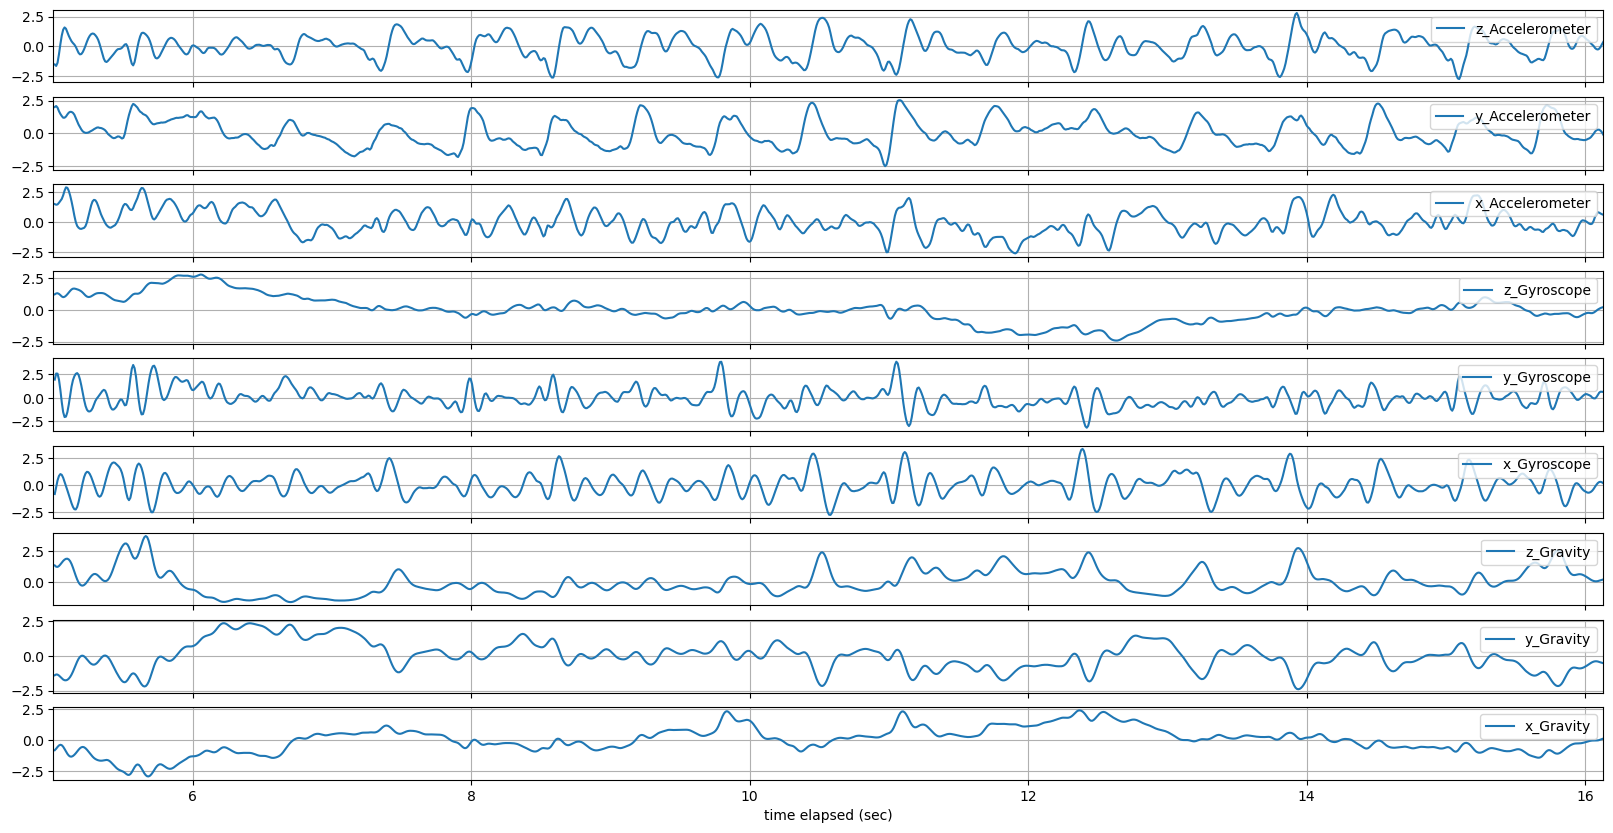

In [8]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for detecting a fall. Based on the measurements at a specific point of time, it is difficult to determine whether someone has fallen. Instead, it would be more appropriate to perform the fall detection over _segments_ of time. In this part you will extract features that will be used for detecting falls. But first all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`.

In [9]:
#// BEGIN_TODO [5ARB0_FallDetector_3_1] Merge all datasets

# data_dir should contain the 15 directories containing the CSV data
# 5 directories for the falling condition (directory name prefixed with "Fall")
# 5 directories for the sitting condition (directory name prefixed with "Sit")
# 5 directories for the standing condition (directory name prefixed with "Stand")


def merge_individual_data(data_dir):
    data_merged_individual = pd.DataFrame()
    with os.scandir(data_dir) as it:
        for entry in it:
            if entry.is_dir() and entry.name.startswith(("Fall", "Sit", "Stand")):
                data = read_and_merge(entry.path)
                data_trimmed = trim_data(data)
                data_norm = normalize_data(data_trimmed)
                data_merged_individual = pd.concat([data_merged_individual, data_norm])
    return data_merged_individual


# data_dir_youming = r"./Data"  
# data_merged_youming = merge_individual_data(data_dir_youming)
# data_merged_youming.to_csv('youming.csv')

def merge_all_participants_data(data_dir):
    data_merged_all = pd.DataFrame()
    
    with os.scandir(data_dir) as it:
        for entry in it:
            if entry.is_file() and entry.name.endswith('.csv'):
                data_individual = pd.read_csv(entry.path, usecols=lambda column: column != 'Unnamed: 0')
                data_merged_all = pd.concat([data_merged_all, data_individual])
    data_merged_all.reset_index(drop=True, inplace=True)
    
    return data_merged_all


data_dir = r"./Data"
data_merged = merge_all_participants_data(data_dir)
data_merged.to_csv('./Data/merged_data.csv', index=False)


#// END_TODO [5ARB0_FallDetector_3_1]

In [10]:
data_merged

,seconds_elapsed,z_Accelerometer,y_Accelerometer,x_Accelerometer,z_Gyroscope,y_Gyroscope,x_Gyroscope,z_Gravity,y_Gravity,x_Gravity
0,5.001393,0.039321,-0.034309,-0.162610,0.128647,0.164851,0.048297,1.012417,0.464590,-0.507963
1,5.020922,-0.065016,0.013514,-0.182357,0.153546,0.166490,0.085815,1.004574,0.485025,-0.500854
2,5.040451,-0.143201,0.035046,-0.200932,0.137984,0.199603,0.041386,0.997107,0.503948,-0.494553
3,5.059979,-0.092095,0.019981,-0.213406,0.109194,0.222552,-0.016866,0.991188,0.518502,-0.489982
4,5.079508,0.024657,0.048791,-0.210501,0.118531,0.215995,-0.043030,0.986484,0.530648,-0.485514
...,...,...,...,...,...,...,...,...,...,...
171521,16.098319,0.198830,-0.259764,-0.280994,-0.331485,-0.314388,0.218673,-1.009887,0.985924,0.987011
171522,16.108375,0.191280,-0.242063,-0.271436,-0.329594,-0.283526,0.208361,-1.008103,0.977105,0.971747
171523,16.118430,0.187520,-0.245613,-0.248294,-0.324408,-0.241150,0.187485,-1.006048,0.968744,0.958602
171524,16.128486,0.180883,-0.244626,-0.219206,-0.310615,-0.175045,0.183398,-1.003084,0.960662,0.950171


### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert data frame to matrix
In order to extract features from the recording, first convert the dataframe to a Numpy matrix called `mat`. This matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the fall detector.

In [11]:
#// BEGIN_TODO [5ARB0_FallDetector_3_2] Convert data frame to matrix

time_vector = data_merged['seconds_elapsed'].copy()

if 'seconds_elapsed' in data_merged.columns:
    data_merged.drop(columns=['seconds_elapsed'], inplace=True)  
mat = data_merged.select_dtypes(include=[np.number]).values  


# print(mat.shape)  


#// END_TODO [5ARB0_FallDetector_3_2]

### End of exercise 3.2
---
---

Now that the data frame has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features. As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of the matrix `mat`. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_)

In [12]:
#// BEGIN_TODO [5ARB0_FallDetector_3_3] Process segments

import numpy as np

def process_segment(mat, fun, L, K):

    num_rows = mat.shape[0]
    num_segments = (num_rows - L) // (L - K) + 1
    results = []
    
    for i in range(num_segments):
        start_idx = i * (L - K)
        end_idx = start_idx + L
        
        segment = mat[start_idx:end_idx, :]
        if fun == "mean":
            result = np.mean(segment, axis=0)
        elif fun == "std":
            result = np.std(segment, axis=0)
        elif fun == "minimum":
            result = np.min(segment, axis=0)
        elif fun == "maximum":
            result = np.max(segment, axis=0)
        else:
            raise ValueError("Invalid function specified")
        results.append(result)
        
    return np.array(results)


#// END_TODO [5ARB0_FallDetector_3_3]

In [13]:
Y_mean = process_segment(mat, "mean", 100, 50)
Y_std = process_segment(mat, "std", 100, 50)
Y_minimum = process_segment(mat, "minimum", 100, 50)
Y_maximum = process_segment(mat, "maximum", 100, 50)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them into a single matrix. Create the matrix `features` which concatenates the above results along the appropriate axis.

In [14]:
#// BEGIN_TODO [5ARB0_FallDetector_3_4] Concatenate features

# Concatenate the resulting matrices to form the features matrix
features = np.concatenate([Y_mean, Y_std, Y_minimum, Y_maximum], axis=1)

#// END_TODO [5ARB0_FallDetector_3_4]

In [15]:
# features

### End of exercise 3.4
---
---

## Part 4: Fall detector
In this part of the assignment we will use the previously implemented data analysis methods to create a simple fall detector. You will be given more freedom to experiment with the different techniques used.

During this part you can make use of the `sklearn` (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets.

In [16]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

---
---
### Exercise 4.1: Fall detector
In this assignment you will create your own fall detector, using the previously recorded data and learned data analysis methods. You are free to add more features to the dataset if you want. Possible steps include: 1) feature extraction, 2) data compression and 3) clustering.

In [22]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own 
# cluster and poorly matched to neighboring clusters.

def evaluate_clustering(features, reduction_method, cluster_method, desired_variance, n_clusters):
    
    if reduction_method == 'PCA':
        reducer = PCA(desired_variance)
    elif reduction_method == 'ICA':
        # We are using the number of components that PCA would choose for the desired variance.
        n_components = PCA(desired_variance).fit(features).n_components_
        reducer = FastICA(n_components=n_components, max_iter=3000, tol=1e-4)
    else:
        raise ValueError("Invalid Reduction Method")
        
    reduced_features = reducer.fit_transform(features)
    
    if cluster_method == 'KMeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif cluster_method == 'GMM':
        clusterer = GaussianMixture(n_components=n_clusters, random_state=42)
    else:
        raise ValueError("Invalid Clustering Method")
        
    clusterer.fit(reduced_features)
    labels = clusterer.predict(reduced_features)
    
    score = silhouette_score(reduced_features, labels)
    
    return score, reduced_features, labels




#// END_TODO [5ARB0_FallDetector_4_1]

In [23]:
combinations = [('PCA', 'KMeans'), ('PCA', 'GMM'), ('ICA', 'KMeans'), ('ICA', 'GMM')]
desired_variance = 0.95  # 95% of the variance
n_clusters = 3  # You can change based on your needs

best_score = -1
best_combination = None
best_features = None
best_labels = None

for reduction_method, cluster_method in combinations:
    score, reduced_features, labels = evaluate_clustering(features, reduction_method, cluster_method, desired_variance, n_clusters)
    if score > best_score:
        best_score = score
        best_combination = (reduction_method, cluster_method)
        best_features = reduced_features
        best_labels = labels
    print(f"{reduction_method} + {cluster_method}: Silhouette Score = {score}")

print(f"Best Combination: {best_combination} with Silhouette Score = {best_score}")


PCA + KMeans: Silhouette Score = 0.281759104058176
PCA + GMM: Silhouette Score = 0.23646872396556018


/Applications/Anaconda/anaconda3/envs/environment/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA + KMeans: Silhouette Score = 0.06788899473721316


/Applications/Anaconda/anaconda3/envs/environment/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA + GMM: Silhouette Score = 0.02330687660604538
Best Combination: ('PCA', 'KMeans') with Silhouette Score = 0.281759104058176


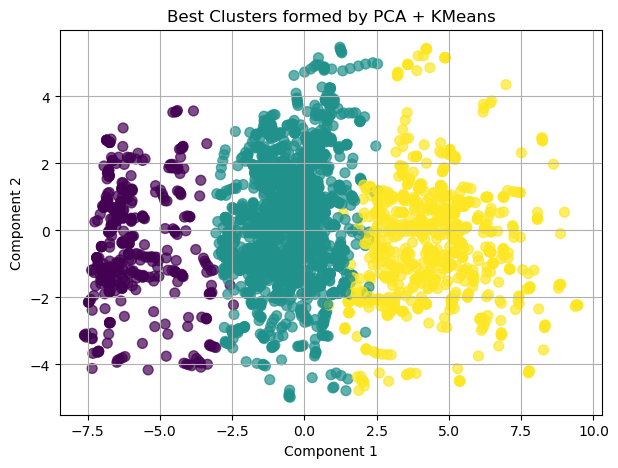

In [24]:
plt.figure(figsize=(7, 5))
plt.scatter(best_features[:, 0], best_features[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f'Best Clusters formed by {best_combination[0]} + {best_combination[1]}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Fall classification
Use your fall detector to classify when someone has fallen. Plot your fall classification over time.

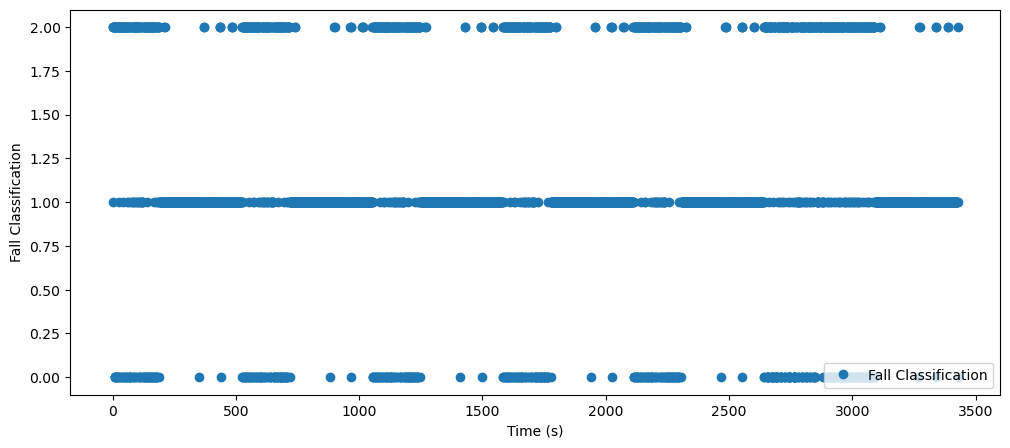

In [25]:
#// BEGIN_TODO [5ARB0_FallDetector_4_2] Classify falls

num_points = len(best_labels)  
time_vector = np.linspace(0, num_points, num_points, endpoint=False) 



plt.figure(figsize=(12, 5))
plt.plot(time_vector, best_labels, 'o', label='Fall Classification')
plt.xlabel('Time (s)')
plt.ylabel('Fall Classification')
plt.legend()
plt.show()
#// END_TODO [5ARB0_FallDetector_4_2]

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Classification improvements
You might have noticed that it is not easy to create a fall detector. How do you think that you could improve the performance? Please carefully describe the current flaws and ways to deal with them, together with a list of next steps that you would take. Please elaborate on your answer.

### End of exercise 4.3
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.